# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


            Sales
Date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
...           ...
1979-10-01   9.99
1980-01-01  16.20
1980-04-01  14.67
1980-07-02  16.02
1980-10-01  11.61

[84 rows x 1 columns]


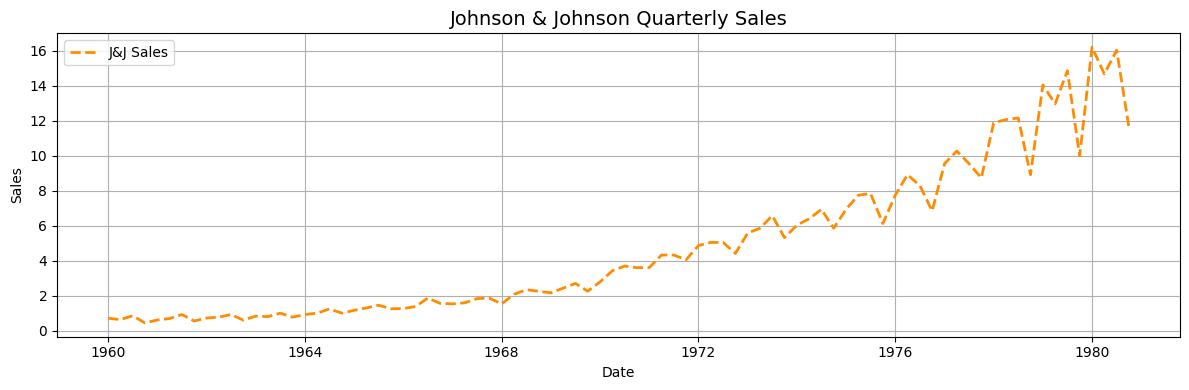

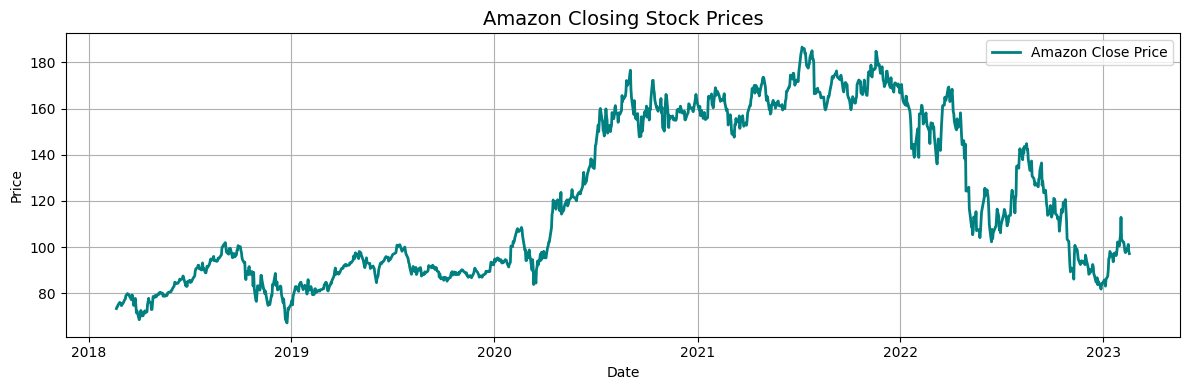

In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# Load Johnson & Johnson data
jj_sales_df = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /jj.csv")
# Rename the 'data' column to 'Sales'
jj_sales_df.columns = ['Date', 'Sales']
# Set 'Date' as the index
jj_sales_df.set_index('Date', inplace=True)
# Convert the index to datetime
jj_sales_df.index = pd.to_datetime(jj_sales_df.index)

# Display basic info
print(jj_sales_df)

# Load Amazon stock price data
amazon_stock_df = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")
# Select only 'Date' and 'Close' columns
amazon_stock_df = amazon_stock_df[['Date', 'Close']]
# Convert 'Date' to datetime
amazon_stock_df['Date'] = pd.to_datetime(amazon_stock_df['Date'])
# Set 'Date' as index
amazon_stock_df.set_index('Date', inplace=True)

# Plot Johnson & Johnson sales data
plt.figure(figsize=(12, 4))
plt.plot(jj_sales_df, color='darkorange', linestyle='--', linewidth=2, label='J&J Sales')  # Changed color/style
plt.title('Johnson & Johnson Quarterly Sales', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Amazon closing stock price data
plt.figure(figsize=(12, 4))
plt.plot(amazon_stock_df, color='teal', linestyle='-', linewidth=2, label='Amazon Close Price')  # Changed color/style
plt.title('Amazon Closing Stock Prices', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Stationarity Testing and Differencing

In [3]:
# Define ADF test function with improved formatting
def adf_test(series, title=''):
    print(f'\nAugmented Dickey-Fuller Test - {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic      : {result[0]:.4f}')
    print(f'p-value            : {result[1]:.4f}')
    print(f'#Lags Used         : {result[2]}')
    print(f'Number of Observations Used: {result[3]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    print('Conclusion         :', 'Stationary' if result[1] < 0.05 else 'Non-stationary')

# Run ADF test on Johnson & Johnson Sales data
adf_test(jj_sales_df['Sales'], 'Johnson & Johnson Sales')

# Run ADF test on Amazon Closing Stock Price data
adf_test(amazon_stock_df['Close'], 'Amazon Stock Closing Price')


Augmented Dickey-Fuller Test - Johnson & Johnson Sales
ADF Statistic      : 2.7420
p-value            : 1.0000
#Lags Used         : 11
Number of Observations Used: 72
Critical Values:
   1%: -3.5246
   5%: -2.9026
   10%: -2.5887
Conclusion         : Non-stationary

Augmented Dickey-Fuller Test - Amazon Stock Closing Price
ADF Statistic      : -1.6578
p-value            : 0.4530
#Lags Used         : 0
Number of Observations Used: 1258
Critical Values:
   1%: -3.4356
   5%: -2.8638
   10%: -2.5680
Conclusion         : Non-stationary


# first-order differencing

In [4]:
# Apply first-order differencing to make the series stationary
jj_sales_diff = jj_sales_df['Sales'].diff().dropna()
amazon_close_diff = amazon_stock_df['Close'].diff().dropna()

# Re-run ADF test on differenced Johnson & Johnson Sales data
adf_test(jj_sales_diff, 'Johnson & Johnson Sales - 1st Order Differencing')

# Re-run ADF test on differenced Amazon Closing Stock Price data
adf_test(amazon_close_diff, 'Amazon Stock Closing Price - 1st Order Differencing')



Augmented Dickey-Fuller Test - Johnson & Johnson Sales - 1st Order Differencing
ADF Statistic      : -0.4074
p-value            : 0.9089
#Lags Used         : 10
Number of Observations Used: 72
Critical Values:
   1%: -3.5246
   5%: -2.9026
   10%: -2.5887
Conclusion         : Non-stationary

Augmented Dickey-Fuller Test - Amazon Stock Closing Price - 1st Order Differencing
ADF Statistic      : -36.2508
p-value            : 0.0000
#Lags Used         : 0
Number of Observations Used: 1257
Critical Values:
   1%: -3.4356
   5%: -2.8638
   10%: -2.5680
Conclusion         : Stationary


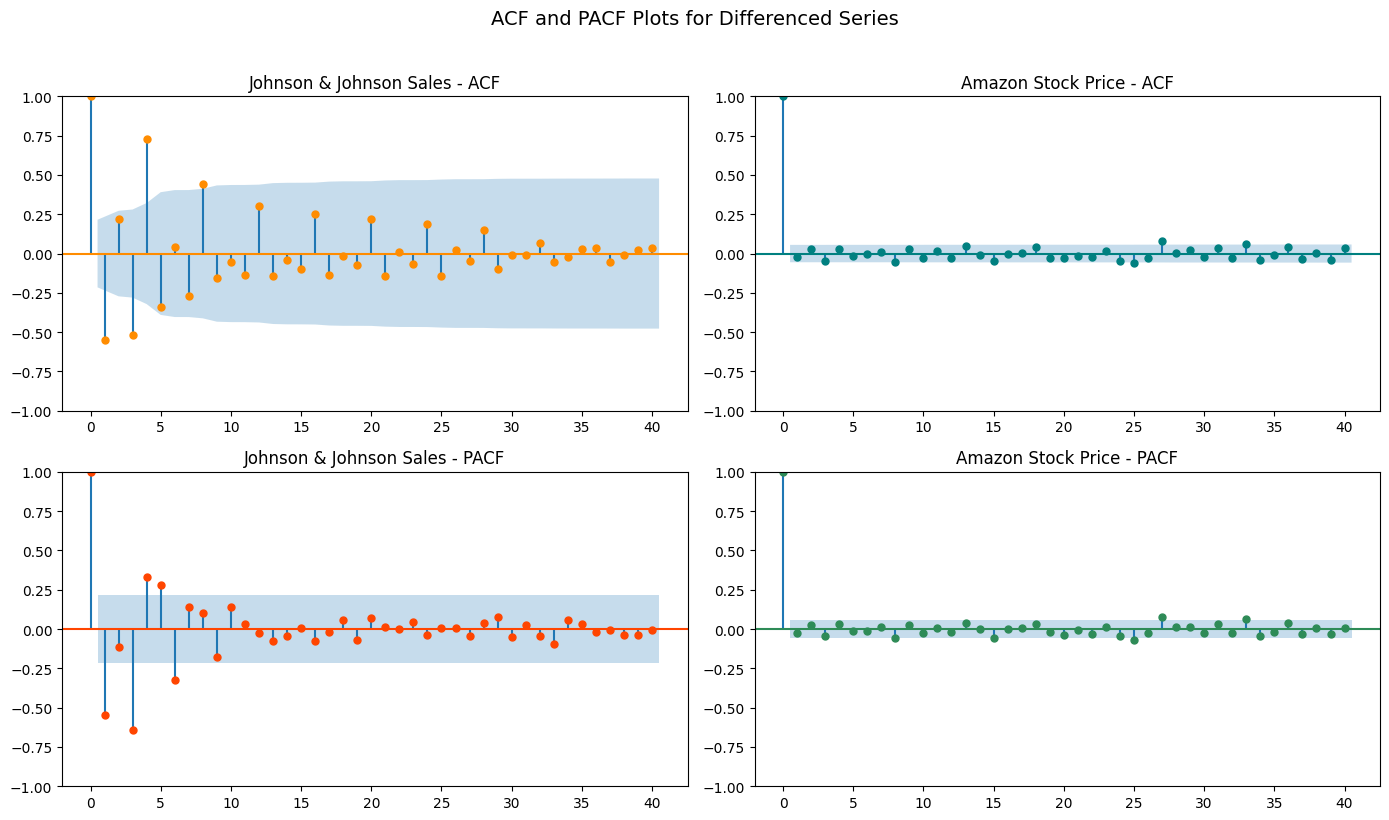

In [5]:
# ACF and PACF plots with updated colors and naming
fig, ax = plt.subplots(2, 2, figsize=(14, 8))

# Johnson & Johnson ACF and PACF
plot_acf(jj_sales_diff, ax=ax[0, 0], lags=40, color='darkorange')
ax[0, 0].set_title("Johnson & Johnson Sales - ACF", fontsize=12)

plot_pacf(jj_sales_diff, ax=ax[1, 0], lags=40, method='ywm', color='orangered')
ax[1, 0].set_title("Johnson & Johnson Sales - PACF", fontsize=12)

# Amazon ACF and PACF
plot_acf(amazon_close_diff, ax=ax[0, 1], lags=40, color='teal')
ax[0, 1].set_title("Amazon Stock Price - ACF", fontsize=12)

plot_pacf(amazon_close_diff, ax=ax[1, 1], lags=40, method='ywm', color='seagreen')
ax[1, 1].set_title("Amazon Stock Price - PACF", fontsize=12)

# General plot layout
plt.suptitle("ACF and PACF Plots for Differenced Series", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


# ARIMA (ARMA) Modelling and Forecast

In [6]:
# Fit ARIMA model to Johnson & Johnson Sales data
# Note: (p,d,q) = (1,1,1) is a placeholder – tune using AIC/BIC for optimal performance
jj_arima_model = ARIMA(jj_sales_df['Sales'], order=(1, 1, 1))
jj_arima_fit = jj_arima_model.fit()
print("Johnson & Johnson ARIMA Model Summary:\n")
print(jj_arima_fit.summary())

# Fit ARIMA model to Amazon Closing Stock Price
# Note: (p,d,q) = (1,1,1) is a placeholder – tune using AIC/BIC for optimal performance
amazon_arima_model = ARIMA(amazon_stock_df['Close'], order=(1, 1, 1))
amazon_arima_fit = amazon_arima_model.fit()
print("\nAmazon ARIMA Model Summary:\n")
print(amazon_arima_fit.summary())


Johnson & Johnson ARIMA Model Summary:

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -128.371
Date:                Sat, 12 Apr 2025   AIC                            262.742
Time:                        06:31:39   BIC                            269.998
Sample:                             0   HQIC                           265.657
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3277      0.090     -3.657      0.000      -0.503      -0.152
ma.L1         -0.4313      0.093     -4.662      0.000      -0.613      -0.250
sigma2      

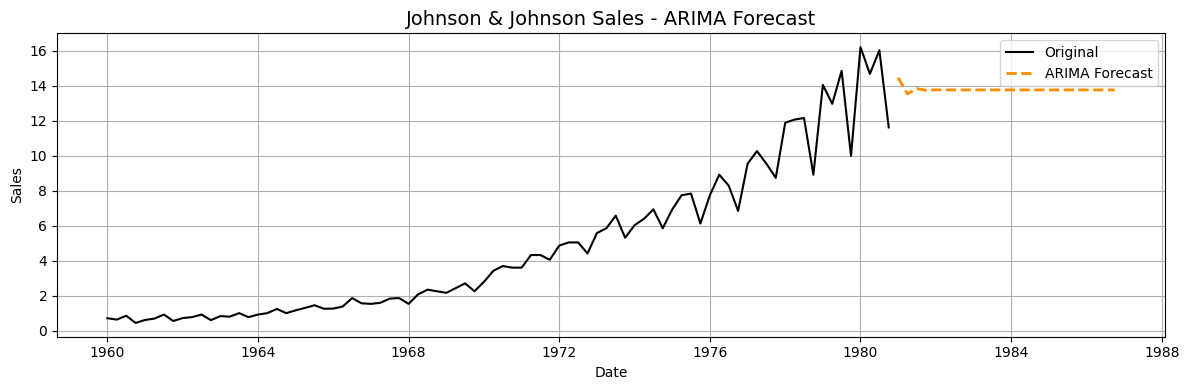

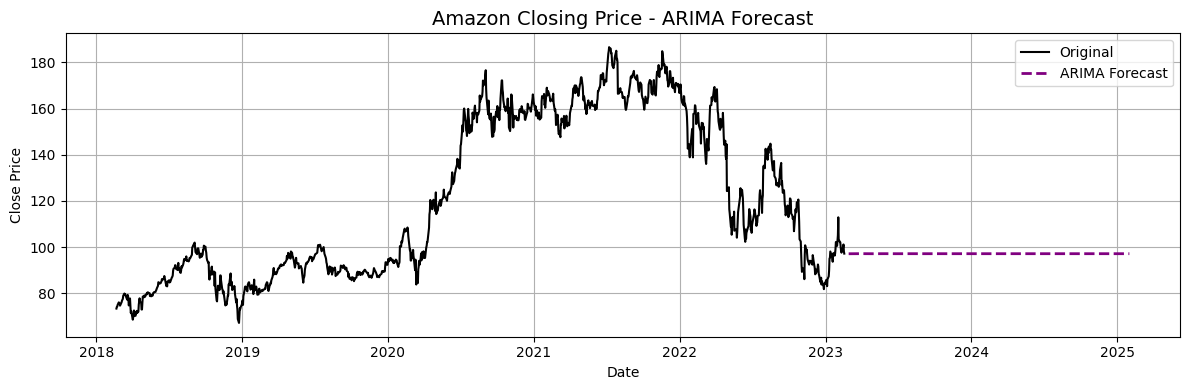

In [7]:
# -----------------------------
# ARIMA Forecast Plots with Custom Colors
# -----------------------------

# Forecast 24 periods ahead (Quarterly for JJ, Monthly for Amazon)
jj_forecast = jj_arima_fit.forecast(steps=24)
amazon_forecast = amazon_arima_fit.forecast(steps=24)

# Plot Johnson & Johnson Sales Forecast (Quarterly)
plt.figure(figsize=(12, 4))
plt.plot(jj_sales_df['Sales'], label='Original', color='black')
plt.plot(pd.date_range(start=jj_sales_df.index[-1] + pd.offsets.QuarterEnd(), periods=24, freq='Q'),
         jj_forecast, label='ARIMA Forecast', color='darkorange', linestyle='--', linewidth=2)
plt.title('Johnson & Johnson Sales - ARIMA Forecast', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Amazon Closing Price Forecast (Monthly)
plt.figure(figsize=(12, 4))
plt.plot(amazon_stock_df['Close'], label='Original', color='black')
plt.plot(pd.date_range(start=amazon_stock_df.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M'),
         amazon_forecast, label='ARIMA Forecast', color='purple', linestyle='--', linewidth=2)
plt.title('Amazon Closing Price - ARIMA Forecast', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Neural Network Forecasting (LSTM / GRU)

In [8]:
# -----------------------------
# Prepare data for RNN
# -----------------------------
def prepare_data(series, n_lags=12):
    """
    Transforms a time series into sequences for RNN input.

    Parameters:
    - series: normalized 1D time series
    - n_lags: number of time steps to use as input

    Returns:
    - X: sequences of shape (samples, timesteps)
    - y: target values
    """
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# -----------------------------
# Normalize data using MinMaxScaler
# -----------------------------

# Johnson & Johnson Sales
scaler_jj = MinMaxScaler()
jj_scaled = scaler_jj.fit_transform(jj_sales_df['Sales'].values.reshape(-1, 1))
X_jj, y_jj = prepare_data(jj_scaled)

# Amazon Closing Price
scaler_amazon = MinMaxScaler()
amazon_scaled = scaler_amazon.fit_transform(amazon_stock_df['Close'].values.reshape(-1, 1))
X_amazon, y_amazon = prepare_data(amazon_scaled)

# -----------------------------
# Reshape input for RNN [samples, timesteps, features]
# -----------------------------
X_jj = X_jj.reshape((X_jj.shape[0], X_jj.shape[1], 1))
X_amazon = X_amazon.reshape((X_amazon.shape[0], X_amazon.shape[1], 1))


In [9]:
# Build model (LSTM or GRU)
# -----------------------------
def build_model(input_shape, model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(64, return_sequences=False, input_shape=input_shape))
    else:
        raise ValueError("model_type must be 'LSTM' or 'GRU'")

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [10]:
# -----------------------------
# Prepare data for RNN models
# -----------------------------
def prepare_data(series, n_lags=12):
    """
    Converts a univariate time series into input/output sequences for RNN models.
    """
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# -----------------------------
# Normalize data using MinMaxScaler
# -----------------------------

# Johnson & Johnson Sales Data
scaler_jj = MinMaxScaler()
jj_scaled = scaler_jj.fit_transform(jj_sales_df['Sales'].values.reshape(-1, 1))
X_jj, y_jj = prepare_data(jj_scaled)

# Amazon Closing Stock Price Data
scaler_amazon = MinMaxScaler()
amazon_scaled = scaler_amazon.fit_transform(amazon_stock_df['Close'].values.reshape(-1, 1))
X_amazon, y_amazon = prepare_data(amazon_scaled)

# -----------------------------
# Reshape input data for RNNs: [samples, timesteps, features]
# -----------------------------
X_jj = X_jj.reshape((X_jj.shape[0], X_jj.shape[1], 1))
X_amazon = X_amazon.reshape((X_amazon.shape[0], X_amazon.shape[1], 1))


In [11]:
def train_forecast(X, y, scaler, model_type='LSTM', forecast_steps=24):
    """
    Trains an RNN (LSTM or GRU) model on time series data and forecasts future values.

    Parameters:
    - X: Input sequences, shaped (samples, timesteps, 1)
    - y: Target values, shaped (samples,)
    - scaler: Fitted MinMaxScaler object (for inverse transformation)
    - model_type: 'LSTM' or 'GRU'
    - forecast_steps: Number of future steps to forecast

    Returns:
    - preds: Forecasted values (inverse transformed to original scale)
    """
    # Build RNN model
    model = build_model((X.shape[1], 1), model_type)

    # Add early stopping
    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    # Train the model
    model.fit(
        X, y,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    # Forecast future steps
    last_seq = X[-1]  # Last observed window
    preds = []

    for _ in range(forecast_steps):
        pred = model.predict(last_seq.reshape(1, -1, 1), verbose=0)[0]
        preds.append(pred)
        # Update input sequence with the new prediction
        last_seq = np.append(last_seq[1:], pred).reshape(-1, 1)

    # Inverse scale predictions
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    return preds


In [12]:
# -----------------------------
# Run Forecasts using LSTM and GRU for JJ and Amazon
# -----------------------------

# Johnson & Johnson Forecasts
jj_lstm_forecast = train_forecast(X_jj, y_jj, scaler_jj, model_type='LSTM')
jj_gru_forecast = train_forecast(X_jj, y_jj, scaler_jj, model_type='GRU')

# Amazon Forecasts
amzn_lstm_forecast = train_forecast(X_amazon, y_amazon, scaler_amazon, model_type='LSTM')
amzn_gru_forecast = train_forecast(X_amazon, y_amazon, scaler_amazon, model_type='GRU')


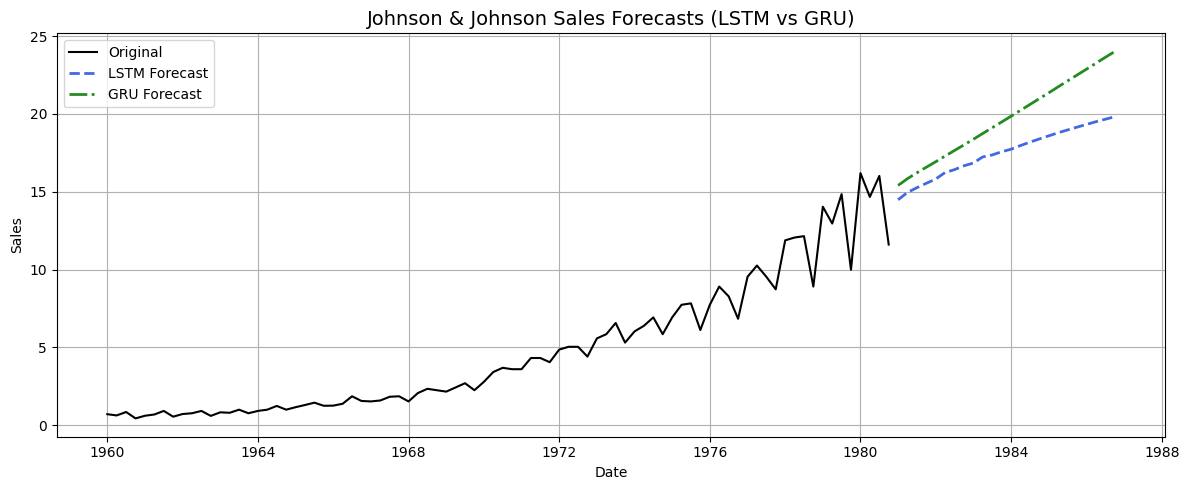

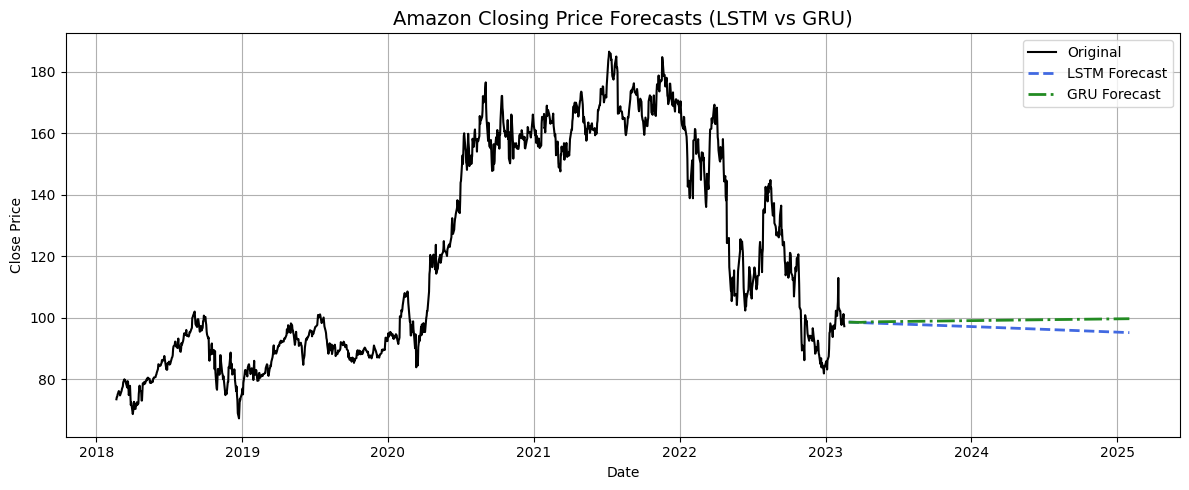

In [13]:
# -----------------------------
# Plot LSTM & GRU Forecasts for JJ and Amazon
# -----------------------------

# Johnson & Johnson Forecasts (Quarterly)
forecast_dates_jj = pd.date_range(
    start=jj_sales_df.index[-1] + pd.offsets.QuarterEnd(), periods=24, freq='Q'
)

plt.figure(figsize=(12, 5))
plt.plot(jj_sales_df['Sales'], label='Original', color='black')
plt.plot(forecast_dates_jj, jj_lstm_forecast, label='LSTM Forecast',
         color='royalblue', linestyle='--', linewidth=2)
plt.plot(forecast_dates_jj, jj_gru_forecast, label='GRU Forecast',
         color='forestgreen', linestyle='-.', linewidth=2)
plt.title('Johnson & Johnson Sales Forecasts (LSTM vs GRU)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Amazon Forecasts (Monthly)
forecast_dates_amazon = pd.date_range(
    start=amazon_stock_df.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M'
)

plt.figure(figsize=(12, 5))
plt.plot(amazon_stock_df['Close'], label='Original', color='black')
plt.plot(forecast_dates_amazon, amzn_lstm_forecast, label='LSTM Forecast',
         color='royalblue', linestyle='--', linewidth=2)
plt.plot(forecast_dates_amazon, amzn_gru_forecast, label='GRU Forecast',
         color='forestgreen', linestyle='-.', linewidth=2)
plt.title('Amazon Closing Price Forecasts (LSTM vs GRU)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# -----------------------------
# Evaluation Function for Forecasts
# -----------------------------
def evaluate(true, pred, model_name="Model"):
    """
    Prints MSE and MAE for the given model forecast.
    """
    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    print(f"{model_name:<15} | MSE: {mse:.4f} | MAE: {mae:.4f}")

# Extract true values for the last 24 time steps
jj_true = jj_sales_df['Sales'][-24:].values
amazon_true = amazon_stock_df['Close'][-24:].values

# -----------------------------
# Johnson & Johnson Forecast Evaluation
# -----------------------------
evaluate(jj_true, jj_lstm_forecast, "JJ LSTM")
evaluate(jj_true, jj_gru_forecast, "JJ GRU")

# -----------------------------
# Amazon Forecast Evaluation
# -----------------------------
evaluate(amazon_true, amzn_lstm_forecast, "Amazon LSTM")
evaluate(amazon_true, amzn_gru_forecast, "Amazon GRU")


JJ LSTM         | MSE: 51.7152 | MAE: 6.9452
JJ GRU          | MSE: 85.7637 | MAE: 9.1230
Amazon LSTM     | MSE: 27.1161 | MAE: 4.0849
Amazon GRU      | MSE: 14.9989 | MAE: 2.7436
